# COGS 108 - Final Project 

# Overview

# Name & GitHub

- Name: Yufei Deng
- GitHub Username: Yukodeng

# Research Question

Does park rating increase with a size? Does it decrease with a higher percentage of ethnic minority population in the neighborhood?

## Background and Prior Work

As San Diego County becomes more diverse in its social make-up, creating spaces for everyone's liking can be a difficult task. Factors driving visitation may include geographic proximity to transportation (accessibility), park features (size, green space, water bodies), and the variety of activities (e.g. natural scenes, sports grounds, themed events, etc.). Together, these characteristics contribute to the popularity of parks in San Diego. For example, Balboa Park is among the most visited place in San Diego, drawing visitors of different age to its natural landscapes and historical architectures. Although not all spaces could be as well-planned and funded, knowing what factors appeals to visitors can help optimize park planning and improve residents' lives.

I am interested in studying factors that underly park popularity. A similar question was asked by Hamstead et al. (2018)[1], who researched on parks in New York City. They extracted data from geo-located social media (GSM)--Flickr and Twitter--as indicators of visitation rates to the 2143 parks across NYC. Then, using regression models, they tests the three potential predictors of visitation rate: 1). Park facilities and characteristics; 2). Accessibility; 3). Neighborhood socio-demographic characteristics. The study found that, indeed, visitation increases with proximity to public transportation, water bodies, and athletic fields. However, it is negatively associated with a higher proportion of ethnic minorities in the neighborhood. The latter part of the finding contrast with results of some of the past studies. It motivates me to also look at the relation between park ratings and the percentage of racial minorities in the neighborhood.

The finding has many implications. The study Liu et al. (2015)[2] integrated a model that categorize factors influencing park visit to three levels: intrapersonal (psychological factors); interpersonal (interactions dependent on others); and structural (environmental factors such as the proximity of facilities). The fact that proportion of ethnic minorities population is negatively associated with park visitation rates can be attributed to neighborhood socio-economic factors, which is environmental, or it can be accounted for by psychological variations between racial and ethnic groups. In fact, studies have found that older adults, racial or ethnic minorities, females, and lower-income families were more likely to be infrequent or nonusers of park. This means that park visitation patterns vary between individuals across age, ethnicity, income, education, personality, etc. 

My final research will be a preliminary exploration on the gorund of these studies. Instead of using answers from questionnaires or soical media that indicate park visitation, I use park ratings and the number of reviews on Yelp as indicators of park popularity. I chose park size and neighborhood racial and ethnic group population percentage as two potential predictors of park popularity. These studies provide me ideas to analyze data and interpret my findings.


References:
- 1) Geolocated social media as a rapid indicator of park visitation and equitable park access. https://doi.org/10.1016/j.compenvurbsys.2018.01.007
- 2) The impact of socio-demographic, environmental, and individual factors on urban park visitation in Beijing, China. https://doi.org/10.1016/j.landurbplan.2018.08.004

# Hypothesis


*Fill in your hypotheses here*

# Dataset(s)


__1. San Diego Parks Yelp Data__ 

- Link to the dataset: https://www.yelp.com/developers/documentation/v3/business_search
- Number of observations: 833

1-2 sentences describing each dataset. 

__2. Park Locations Data__
- Link to the dataset: https://data.sandiego.gov/datasets/park-locations/
- Number of observations: 2769

__3.



If you plan to use multiple datasets, add 1-2 sentences about how you plan to combine these datasets.

# Setup

In [77]:
%matplotlib inline

# essentials
import numpy as np
import pandas as pd
import geopandas as gpd

# graphics
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 7)
import seaborn as sns
sns.set_theme(style="ticks", font_scale=2)

# statistical tools
import patsy
import scipy.stats as stats
import statsmodels.api as sm

%config InlineBackend.figure_format ='retina'

# Data Cleaning

## Park Areas and Yelp Ratings

In [78]:
yelp_SD = pd.read_csv('../data/yelp_SD_parks.csv')
park_df = gpd.read_file('../data/parks_datasd.geojson')

In [80]:
print(yelp_SD.shape, park_df.shape)

(833, 10) (2769, 8)


In [65]:
yelp_SD = yelp_SD.drop(columns=['phone','id','url','longitude','latitude','is_closed'])
park_df = park_df.drop(columns=['objectid','name','location','park_type','owner','geometry'])

# Rename columns
park_df = park_df.rename(columns={'alias':'name', 'gis_acres':'acres'})

In [67]:
# Check for missing values
print(yelp_SD.isna().sum())
print(park_df.isna().sum())

name            0
address         0
rating          0
review_count    0
dtype: int64
name     0
acres    0
dtype: int64


In [68]:
# merge park rating and park area
df = pd.merge(yelp_SD, park_df, on='name')

df = df.sort_values(by=('review_count'), ascending=False)
df.head()

,name,address,rating,review_count,acres
0,Balboa Park,"1549 El Prado San Diego, CA 92101",5.0,2105,1089.476460
23,Torrey Pines State Reserve,"12600 N Torrey Pines Rd La Jolla, CA 92037",4.5,1319,198.780945
7,Sunset Cliffs Natural Park,"1253 Sunset Cliffs Blvd San Diego, CA 92107",5.0,935,67.109374
25,Cabrillo National Monument,"1800 Cabrillo Memorial Dr San Diego, CA 92106",4.5,681,153.276913
80,Mission Trails Regional Park,"1 Father Junipero Serra Trl San Diego, CA 92119",4.5,360,451.537474


## Racial Demogrphy Data

In [37]:
demog_df = pd.read_excel('../data/censusacs_2010_zip_all_2020_12_13 06_17.xlsx')

In [38]:
# Drop and rename colummns of the deomographics dataset
demog_df = demog_df.drop(columns=['YEAR'])
demog_df = demog_df.rename(columns={'Zip':'zipcode','RACE':'race','NUMBER':'number'})

# Check if values are standardized
demog_df['race'].unique()

array(['Pacific Islander', 'White', 'Black', 'Other', 'Two or More',
       'American Indian', 'Hispanic', 'Asian'], dtype=object)

In [39]:
race_pop = demog_df.loc[(demog_df['race']=='Black')|
                        (demog_df['race']=='Hispanic')|
                        (demog_df['race']=='White')]

race = race_pop.groupby(['zipcode','race']).sum()

racegrouped = race.groupby(level=0).apply(lambda g: g / g.sum()).reset_index()


In [40]:
AfriAm_perc = racegrouped.loc[racegrouped['race']=='Black',['zipcode','number']]
Hisp_perc = racegrouped.loc[racegrouped['race']=='Hispanic',['zipcode','number']]
White_perc =  racegrouped.loc[racegrouped['race']=='White',['zipcode','number']]

print(AfriAm_perc.shape,Hisp_perc.shape, White_perc.shape)

     zipcode    number
0      91901  0.012566
3      91902  0.040060
6      91905  0.034975
9      91906  0.068387
12     91910  0.044212
..       ...       ...
316    92155  0.049761
319    92173  0.013192
322    92182  0.066241
325    92536  0.006289
328    92672  0.080794

[110 rows x 2 columns] (110, 2) (111, 2)


In [41]:
demogDF = demog_df.groupby('zipcode')['number'].agg([np.sum]).reset_index(level=0)

demogDF = pd.merge(demogDF, AfriAm_perc, on='zipcode')
demogDF = pd.merge(demogDF, Hisp_perc, on='zipcode')
demogDF = pd.merge(demogDF, White_perc, on='zipcode')

demogDF = demogDF.rename(columns={'sum':"total_pop",'number_x':'Black',
                        'number_y':'Hispanic','number':'White'})
demogDF.dtypes

zipcode        int64
total_pop      int64
Black        float64
Hispanic     float64
White        float64
dtype: object

In [42]:
demogDF['zipcode'] = demogDF['zipcode'].astype(np.str)

In [43]:
demogDF.head()

,zipcode,total_pop,Black,Hispanic,White
0,91901,17084,0.012566,0.166490,0.820944
1,91902,17005,0.040060,0.491033,0.468907
2,91905,1669,0.034975,0.274804,0.690221
3,91906,5765,0.068387,0.387834,0.543779
4,91910,76153,0.044212,0.682264,0.273524


# Data Analysis

## Explorative Data Analysis

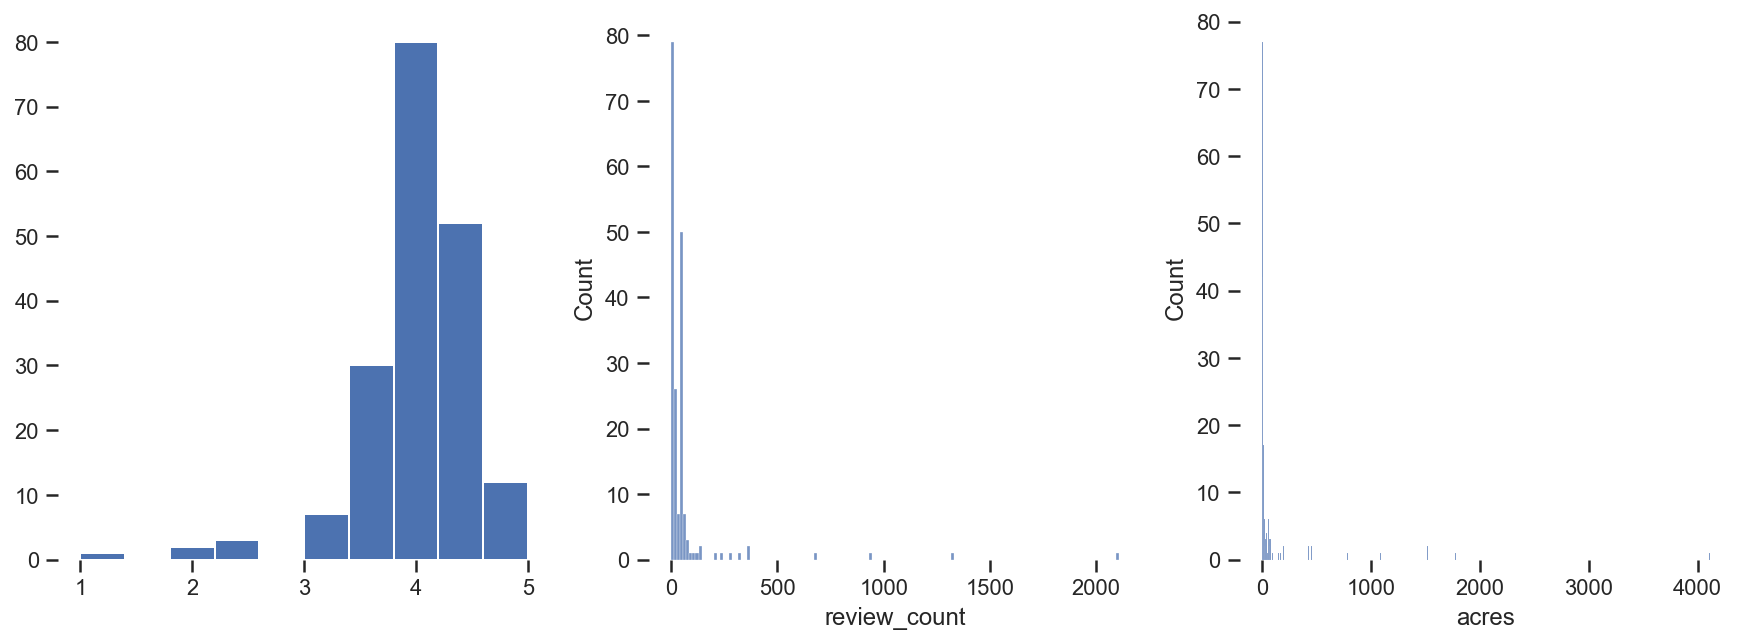

In [59]:
# Plot the rating, review_count, acres distributions
# to check for outliers
f, axes = plt.subplots(1,3,figsize=(15,5))
axes[0].hist(df['rating'])
sns.histplot(df['review_count'], ax=axes[1])
sns.histplot(df['acres'], ax=axes[2])
sns.despine(f,left=True,bottom=True)

In [44]:
# See how many observations would be dropped
df[(df['review_count']<1) | (df['review_count']>=500) | (df['acres']>=1000)].count()

name            9
address         9
rating          9
review_count    9
acres           9
dtype: int64

In [61]:
# Drop outliers
df_drop = df[(df['review_count']<1) | (df['review_count']>=500) 
             | (df['acres']>=1000)]
df = df.drop(df_drop.index)


# Log transform values
#df['ratingCube'] = df['rating'].apply(np.cbrt)
df['review_count10'] = np.log10(df['review_count'])
df['acres10'] = np.log10(df['acres'])

## Testing Rating, Review Count, and Area Distributions for Normality

In [62]:
h_rate = df['rating'].values
h_rev = df['review_count10'].values
h_ac = df['acres10'].values

st_rate, p_rate = stats.normaltest(h_rate)
st_rev, p_rev = stats.normaltest(h_rev)
st_ac, p_ac = stats.normaltest(h_ac)

print('p for rating is:',p_rate,'\n',
      'p for review count10 is:',p_rev,'\n',
      'p for acres10 is:',p_ac)

p for rating is: 3.339746679607665e-14 
 p for review count10 is: 0.014175242565125033 
 p for acres10 is: 0.05977934982497124


Unfortunately, the rating distribution is still right-skewed. 

In [70]:
df['review_count10'][df['review_count'].notnull()]

KeyError: 'review_count10'

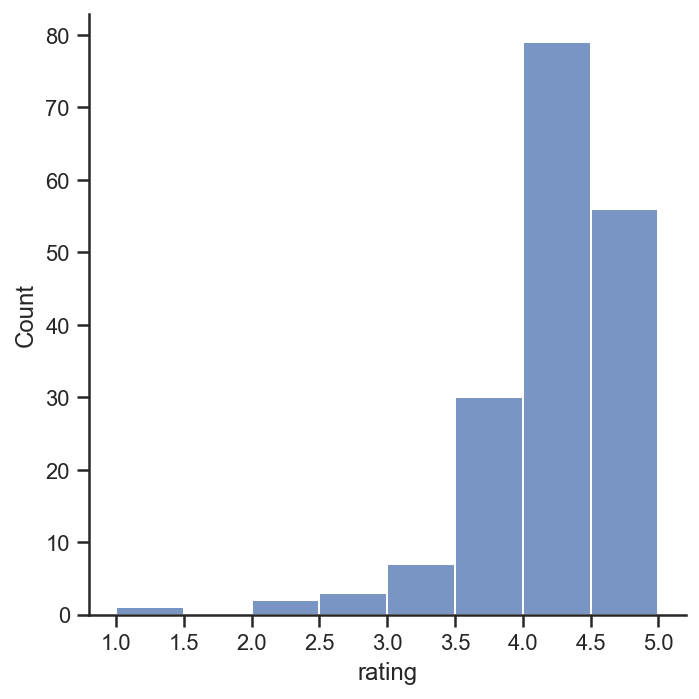

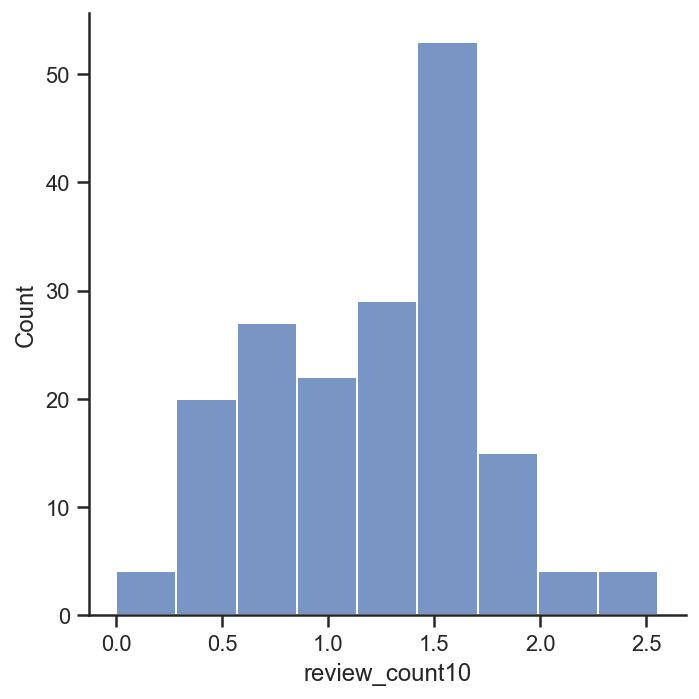

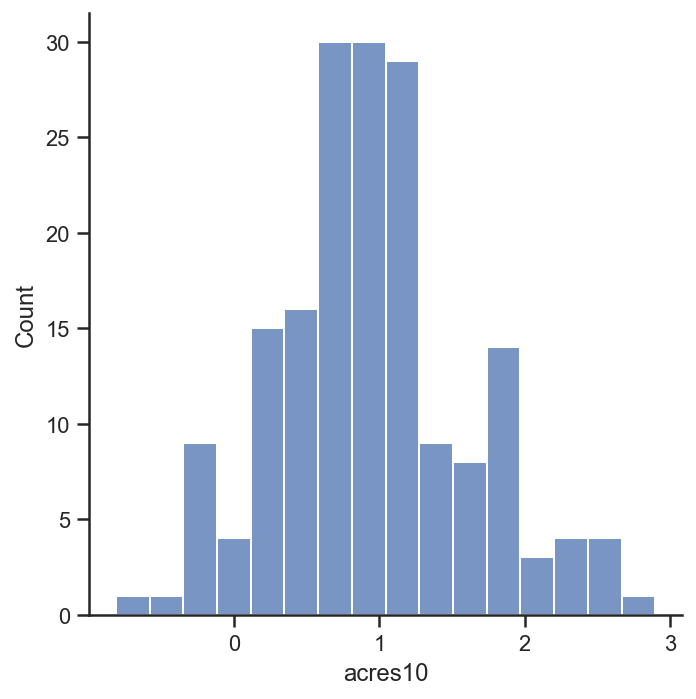

In [63]:
# Check for new plot
f, axes = plt.subplots(1,3,figsize=(15,5))
axes[0].hist(df['rating'])
sns.displot(df['review_count10'][df['review_count'].notnull()])
sns.displot(df['acres10'][df['acres'].notnull()])

## Fitting a Regression Model to Predict Review Counts

In [1]:
sns.scatterplot(x='acres10',y='rating', data=df, s=100)

NameError: name 'sns' is not defined

<AxesSubplot:xlabel='acres10', ylabel='review_count10'>

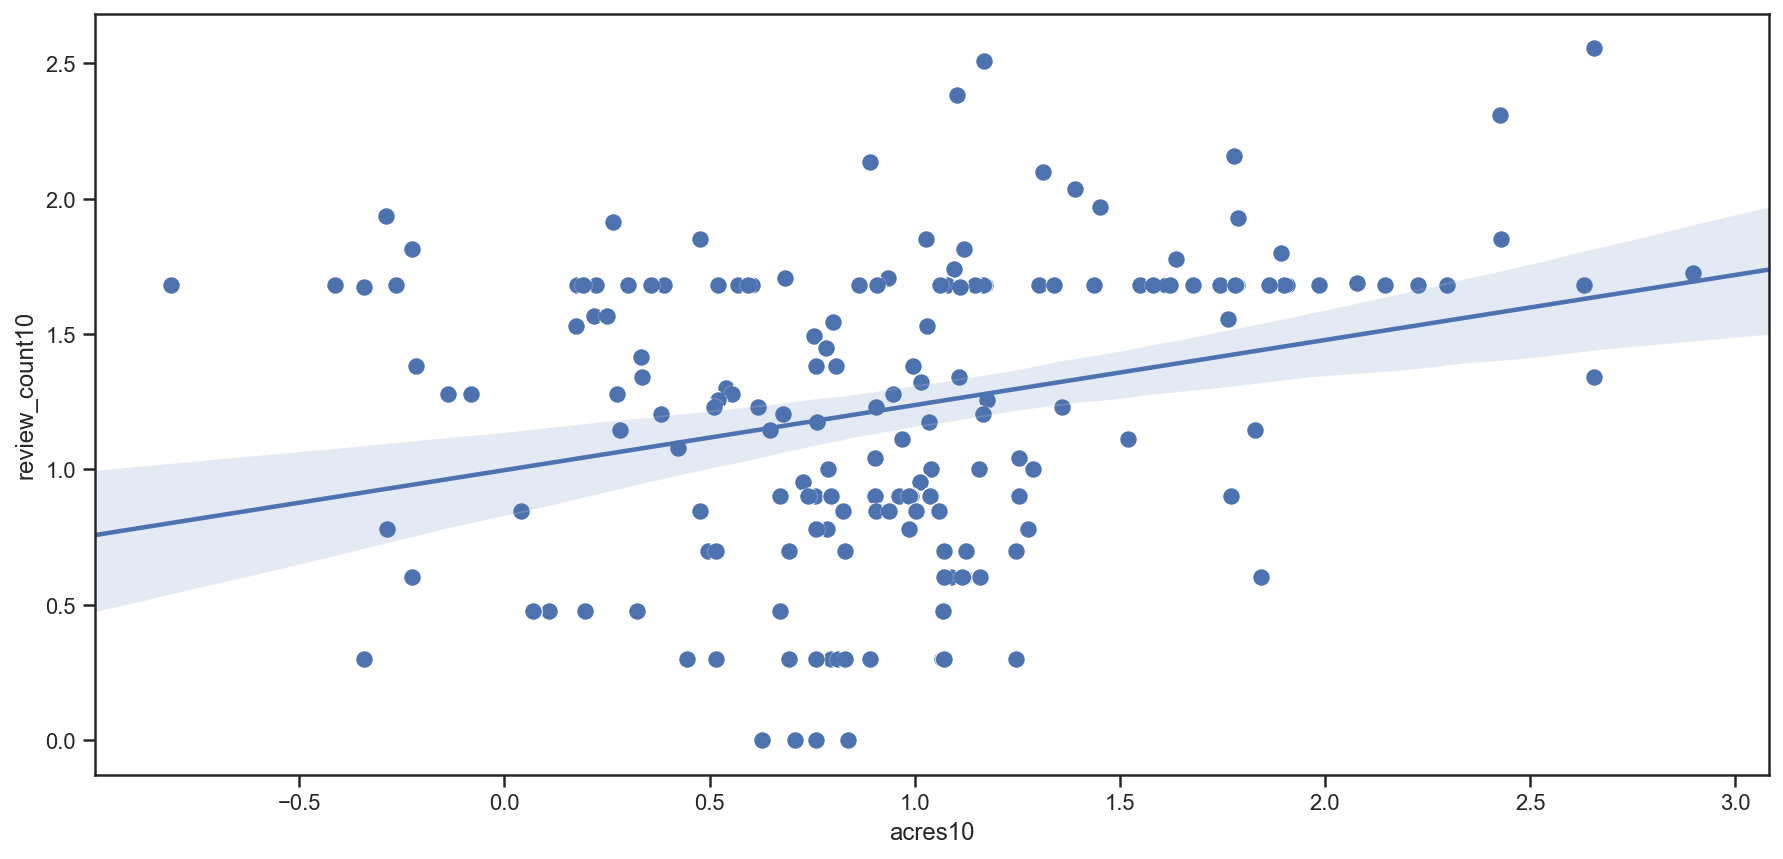

In [82]:
sns.scatterplot(x='acres10',y='review_count10', data=df, s=80)
sns.regplot(x='acres10',y='review_count10', data=df, truncate=False)

In [76]:
#pd.plotting.scatter_matrix(df[['rating','review_count10','acres10']],
   #                       figsize= (15,10))

In [77]:
outcomeRev, predictorsAcr = patsy.dmatrices('review_count10 ~ acres10', df)
mod1 = sm.OLS(outcomeRev, predictorsAcr)
res1 = mod1.fit()
print(res1.summary())

                            OLS Regression Results                            
Dep. Variable:         review_count10   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     15.86
Date:                Tue, 15 Dec 2020   Prob (F-statistic):           9.97e-05
Time:                        04:33:18   Log-Likelihood:                -139.38
No. Observations:                 178   AIC:                             282.8
Df Residuals:                     176   BIC:                             289.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9971      0.070     14.196      0.0

P value is 0.00 (less then alpha 0.01), which successfully rejects the null hypothesis.

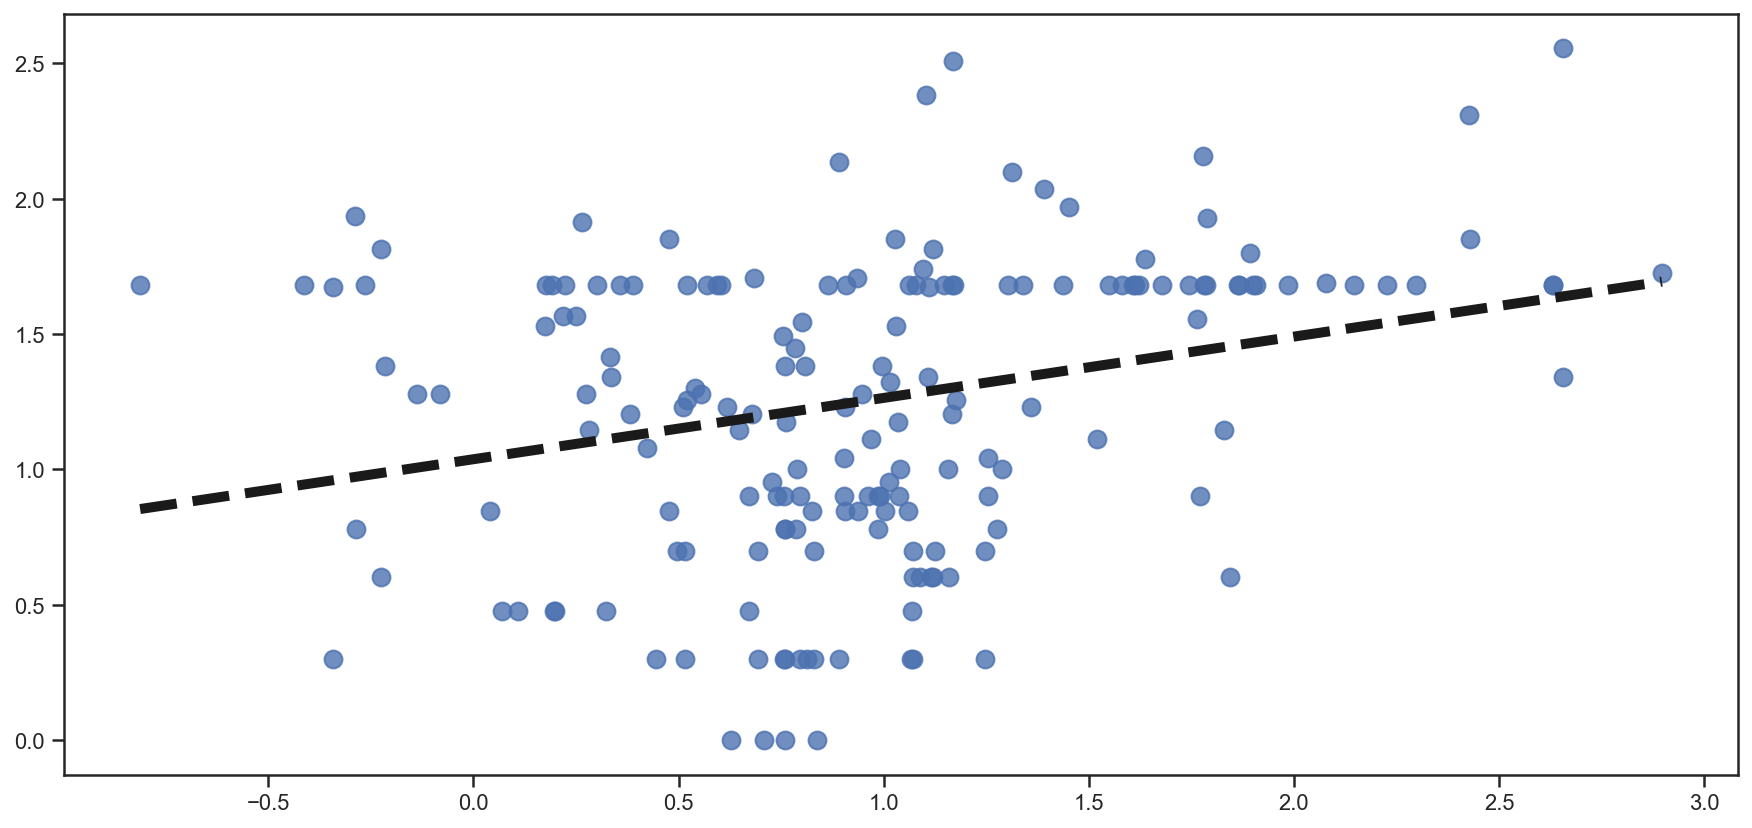

In [80]:
plt.scatter(x=df['acres10'], y=df['review_count10'], 
            s=80,alpha=0.8)
xs = np.array([df['acres10'].min(), df['acres10'].max()])
ys = 1.0374 + 0.2266* xs
plt.plot(xs, ys, '--k', linewidth=5)

In [81]:
outcomeRate, predictorsAcr = patsy.dmatrices('rating ~ acres10', df)
mod2 = sm.OLS(outcomeRate, predictorsAcr).fit()
print(mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.4533
Date:                Tue, 15 Dec 2020   Prob (F-statistic):              0.502
Time:                        04:34:20   Log-Likelihood:                -155.19
No. Observations:                 178   AIC:                             314.4
Df Residuals:                     176   BIC:                             320.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.9547      0.077     51.523      0.0

In [16]:
#sns.scatterplot(x='acres10',y='rating', data=df, s=85)
#sns.despine()
#xs = np.array([df['acres10'].min(), df['acres10'].max()])
#ys = 3.9116 + 0.1072* xs
#plt.plot(xs, ys, '--k', linewidth=6)

##  Exploring the Relation Between Racial Population Percentages and Park Reviews

In [6]:
def address_to_zip(string):
    zip = []
    for str in string:
        if str[-5] == '9':
            zip.append(str[-5:]) 
        else:
            zip.append(np.nan)          
    return zip


yelp_SD['zipcode'] = address_to_zip(yelp_SD['address'])
yelp_SD = yelp_SD.dropna()

yelp_SD = yelp_SD.loc[:,['name','zipcode','rating','review_count']]

In [590]:
yelp_df = yelp_SD.groupby('zipcode').mean().reset_index()

In [592]:
# Create the dataframe with all variables needed
df2 = pd.merge(yelp_df, demogDF, on='zipcode')
df2.describe()

,rating,review_count,total_pop,Black,Hispanic,White
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,4.005038,132.401312,36775.402778,0.053819,0.328370,0.617812
std,0.671858,184.148792,19066.549531,0.054859,0.221183,0.243410
min,1.000000,1.000000,2006.000000,0.004034,0.056037,0.029375
25%,3.796429,31.625000,23740.500000,0.016579,0.155338,0.461692
50%,4.000000,61.204545,37511.500000,0.036511,0.235933,0.705902
75%,4.340909,148.670455,48635.250000,0.071164,0.476309,0.811706
max,5.000000,991.181818,83249.000000,0.311248,0.957433,0.937837


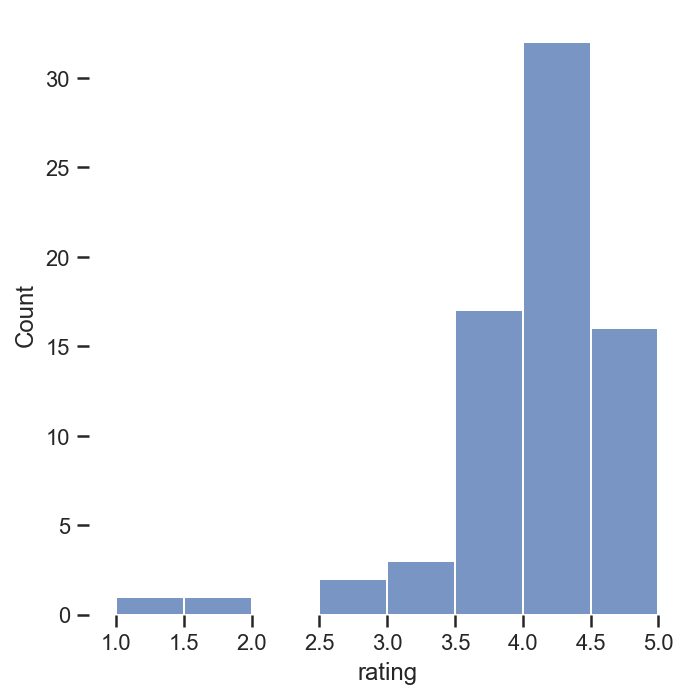

In [593]:
sns.displot(df2['rating'],binwidth=0.5)
sns.despine(bottom=True,left=True)

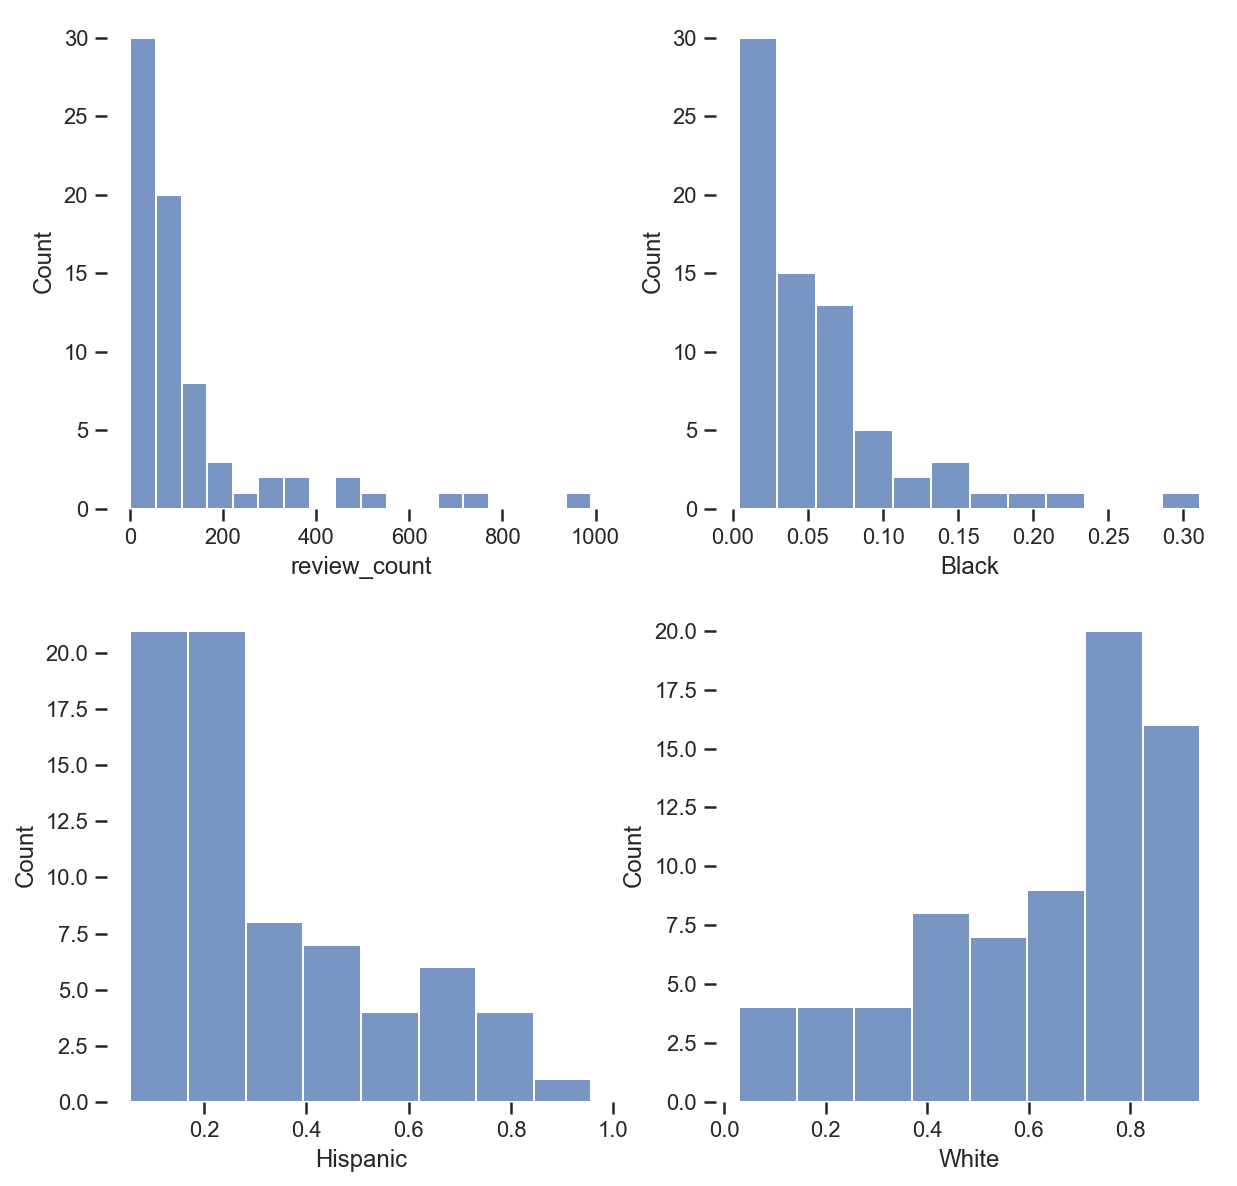

In [594]:
_, axes = plt.subplots(2, 2, figsize=(10,10))

sns.histplot(df2['review_count'],ax=axes[0,0])
sns.histplot(df2['Black'], ax=axes[0,1])
sns.histplot(df2['Hispanic'],ax=axes[1,0])
sns.histplot(df2['White'],ax=axes[1,1])

sns.despine(bottom=True,left=True)

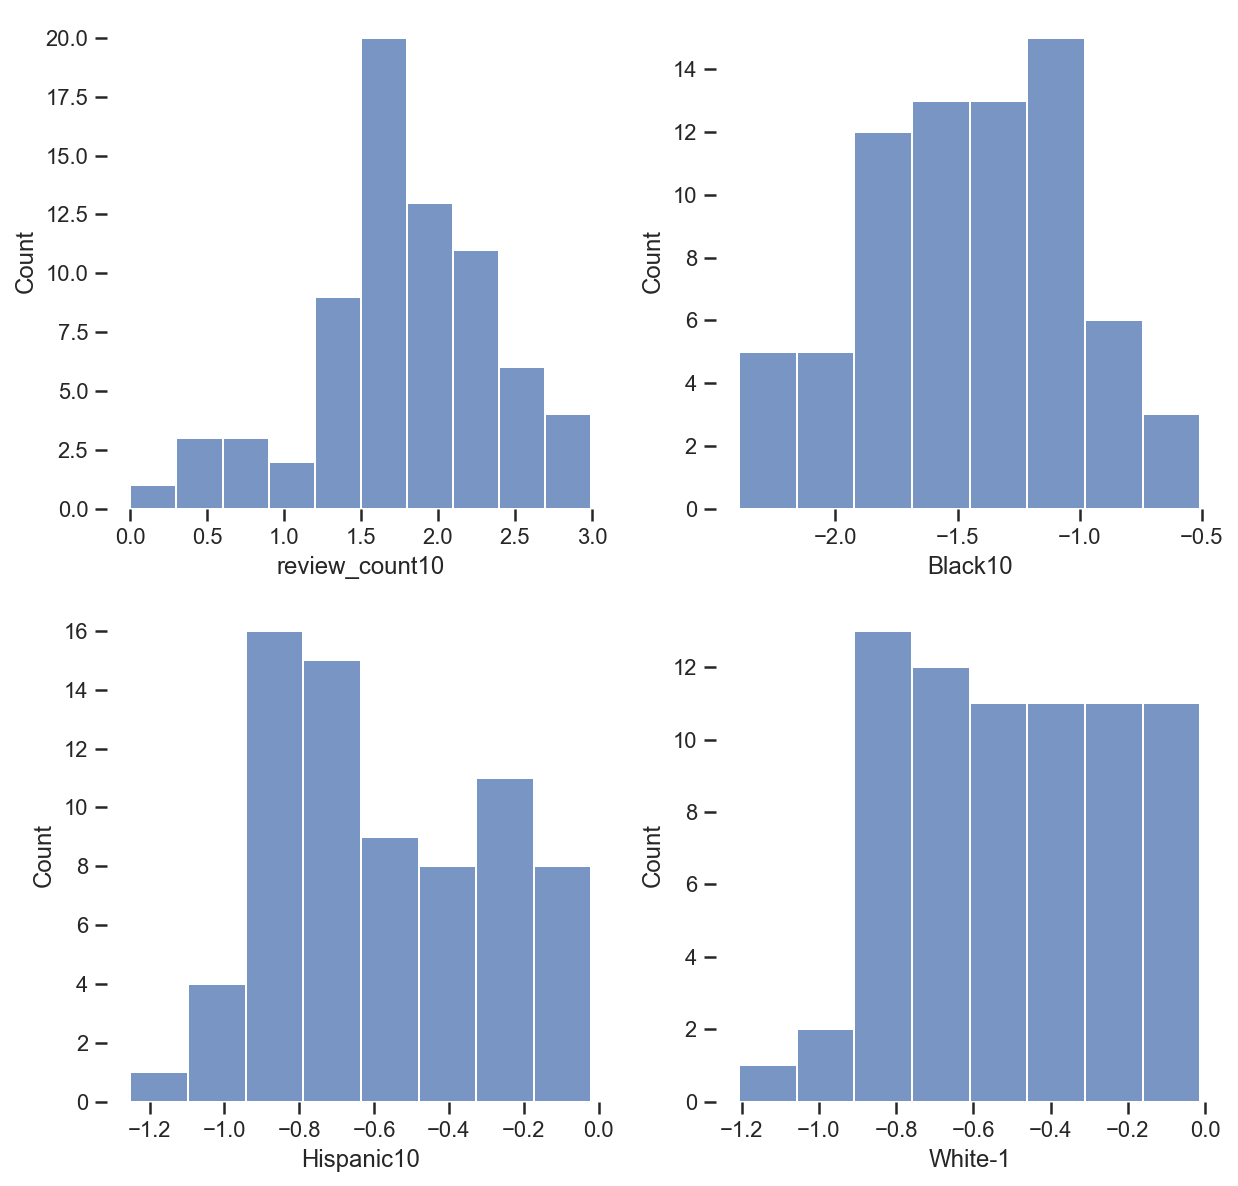

In [620]:
# Value transformation
df2['review_count10'] = np.log10(df2['review_count'])
df2['Black10'] = np.log10(df2['Black'])
df2['Hispanic10'] = np.log10(df2['Hispanic'])
#df2['White1/3'] = np.log(df2['White'])
df2['White-1'] = np.log10(df2['White'].apply(lambda x: 1-x))

# See distributions of transformed data
_, axes = plt.subplots(2,2, figsize=(10,10))

sns.histplot(df2['review_count10'], ax=axes[0,0])
sns.histplot(df2['Black10'], ax=axes[0,1])
sns.histplot(df2['Hispanic10'], ax=axes[1,0])
#sns.histplot(df2['White1/3'], ax=axes[1,1])
sns.histplot(df2['White-1'], ax=axes[1,1])

sns.despine(left=True,bottom=True)

In [621]:
h_rev2 = df2['review_count10'].values
h_blk = df2['Black10'].values
h_hisp = df2['Hispanic10'].values
h_white = df2['White-1'].values

st_rev2, p_rev2 = stats.normaltest(h_rev2)
st_blk, p_blk = stats.normaltest(h_blk)
st_hisp, p_hisp = stats.normaltest(h_hisp)
st_white, p_white = stats.normaltest(h_white)
print(p_rev2, p_blk,p_hisp,p_white)

0.056010435582462645 0.5580237111743576 0.040175678750165686 0.04239314490713347


array([[<AxesSubplot:xlabel='Black10', ylabel='Black10'>,
        <AxesSubplot:xlabel='White-1', ylabel='Black10'>,
        <AxesSubplot:xlabel='Hispanic10', ylabel='Black10'>],
       [<AxesSubplot:xlabel='Black10', ylabel='White-1'>,
        <AxesSubplot:xlabel='White-1', ylabel='White-1'>,
        <AxesSubplot:xlabel='Hispanic10', ylabel='White-1'>],
       [<AxesSubplot:xlabel='Black10', ylabel='Hispanic10'>,
        <AxesSubplot:xlabel='White-1', ylabel='Hispanic10'>,
        <AxesSubplot:xlabel='Hispanic10', ylabel='Hispanic10'>]],
      dtype=object)

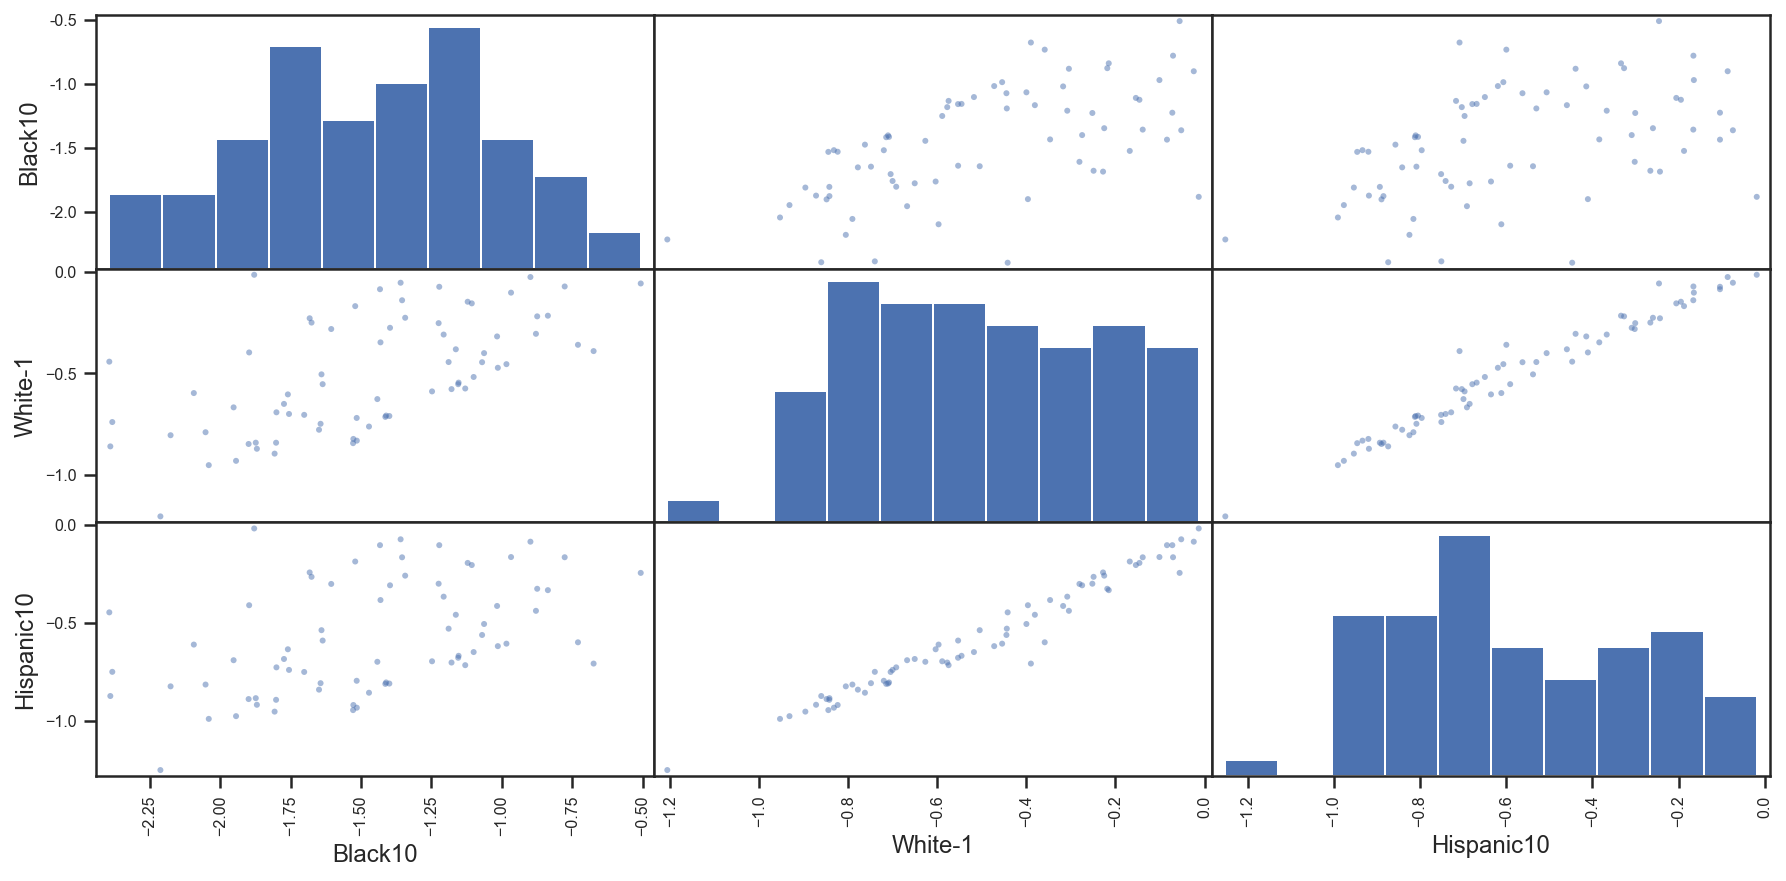

In [623]:
pd.plotting.scatter_matrix(df2[['Black10','White-1','Hispanic10']])

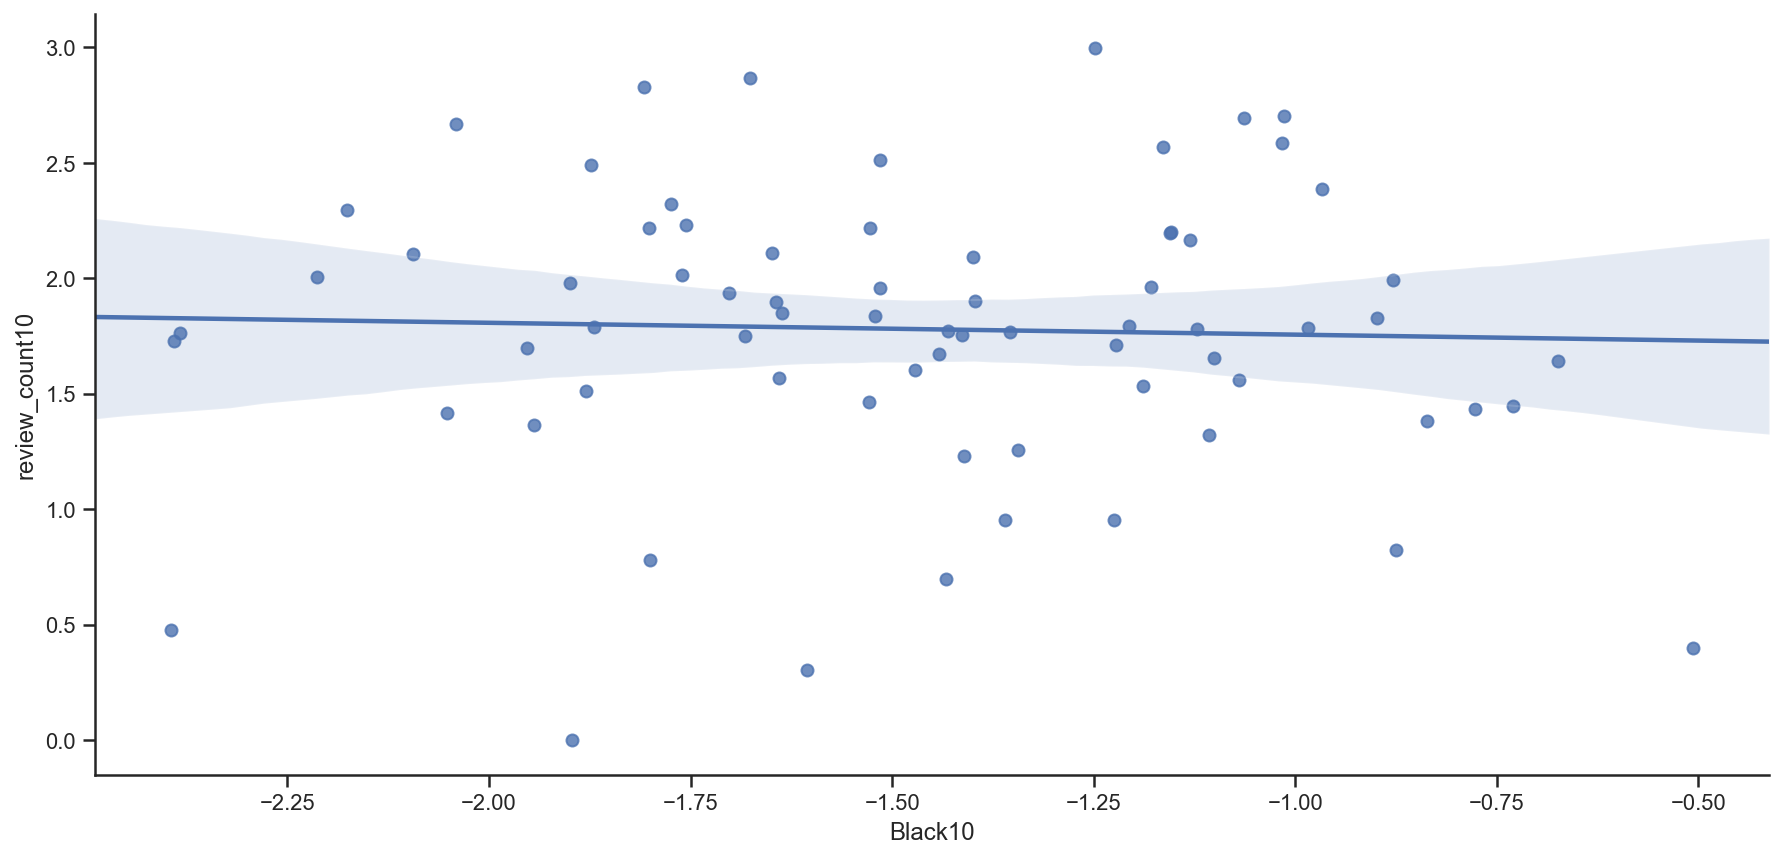

In [626]:
sns.regplot(x='Black10',y='review_count10',data=df2, truncate=False)
sns.despine()

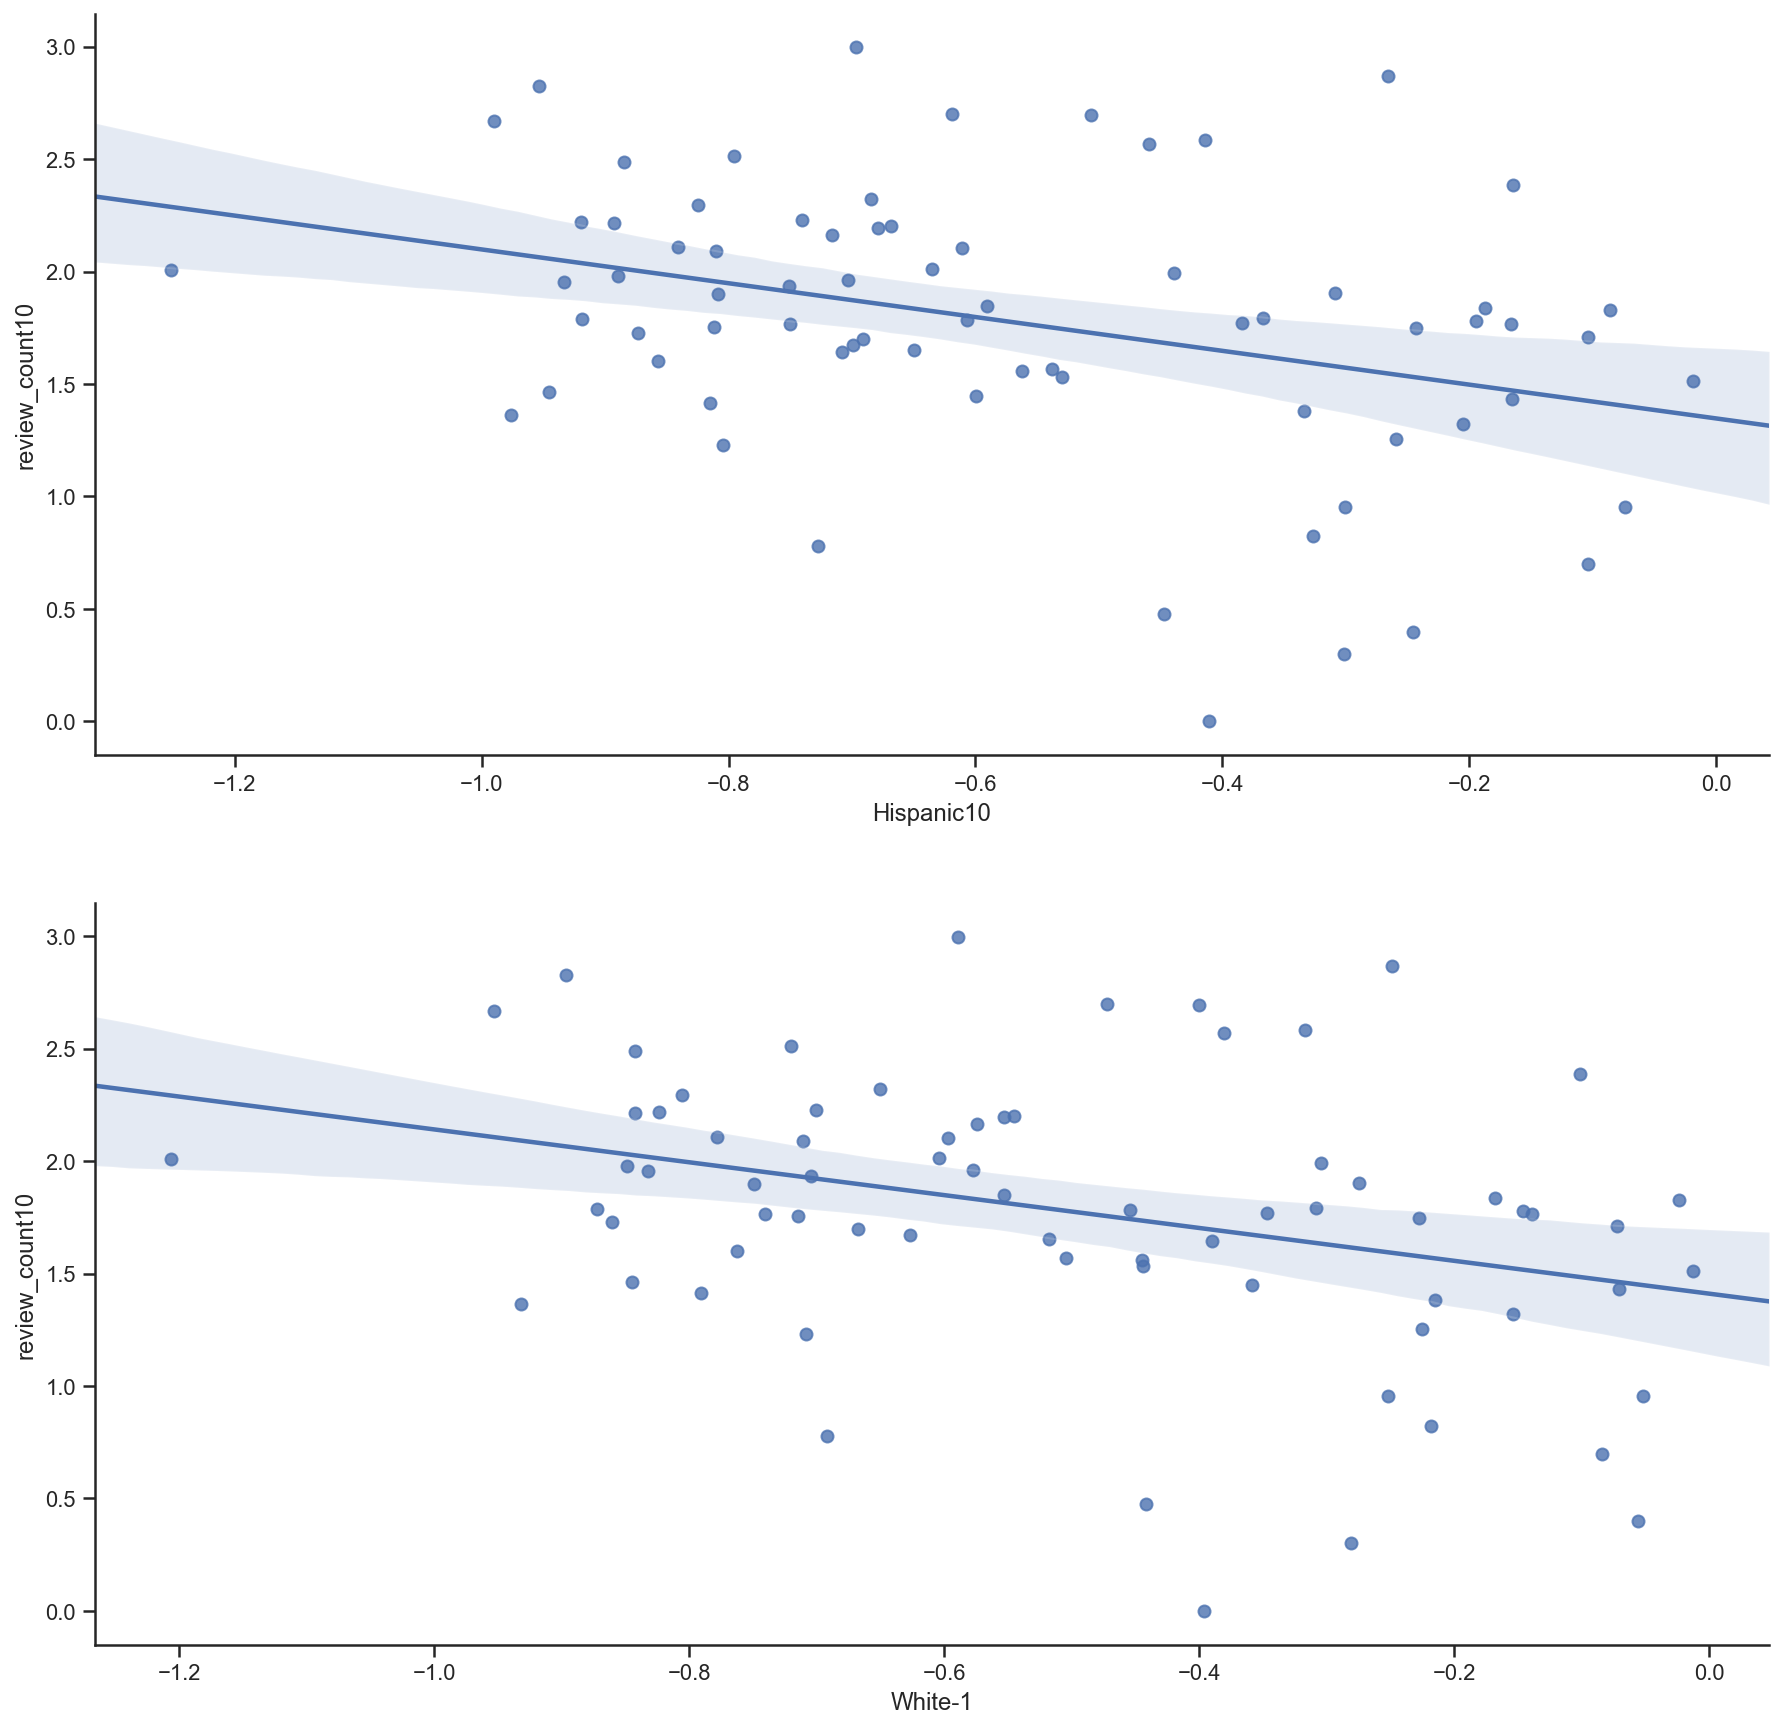

In [625]:
f, axes = plt.subplots(2,1, figsize=(15,15))

sns.regplot(x=df2['Hispanic10'],y=df2['review_count10'],truncate=False, ax=axes[0])
sns.regplot(x=df2['White-1'],y=df2['review_count10'], truncate=False, ax=axes[1])
sns.despine(f)

# Ethics & Privacy

*Fill in your ethics & privacy discussion here*

# Conclusion & Discussion

*Fill in your discussion information here*